In [1]:
import os
import pandas as pd
import numpy as np
import string
from operator import itemgetter
from collections import Counter, OrderedDict

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

from scipy import spatial
import ast

import re
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import gridspec
from math import pi

In [2]:
wine_variety_vectors = pd.read_csv('../raw_data/wine_aromas_nonaromas.csv', index_col='Unnamed: 0')
wine_variety_vectors

,aroma,weight,sweet,acid,salt,piquant,fat,bitter
"Abouriou, Côtes du Marmandais, Southwest France, France",[-3.57883883e+00 -1.20966923e+00 6.70351148e-...,0.739124,0.373864,0.489738,0.464629,0.347010,0.455978,0.324876
"Abouriou, Russian River Valley, California, US",[-1.5796402e+00 3.5908687e+00 -2.5727348e+00 ...,0.478247,0.378831,0.242889,0.464629,0.347010,0.455978,0.719817
"Agiorgitiko, none, Arcadia, Greece",[-6.4688911e+00 -4.8922682e+00 5.9628420e+00 ...,0.638981,0.225799,0.242889,0.464629,0.240055,0.016628,0.324876
"Agiorgitiko, none, Attica, Greece",[-1.3267231e+00 -1.5002778e+00 -3.7853963e+00 ...,1.000000,0.160540,0.242889,0.464629,0.000000,0.455978,0.324876
"Agiorgitiko, none, Corinth, Greece",[-0.23050278 0.8019923 0.7044953 -2.271163...,0.509853,0.300496,0.169084,0.464629,0.347010,0.455978,0.324876
...,...,...,...,...,...,...,...,...
"Zweigelt, none, Wagram-Donauland, Austria",[-1.93111098e+00 -1.31356692e+00 -1.74097583e-...,0.652165,0.285771,0.051258,0.464629,0.311358,0.441958,0.243861
"Zweigelt, none, Weinland Österreich, Austria",[-4.5752165e-01 2.0606184e+00 -1.1869148e-01 ...,0.826082,0.337423,0.244541,0.464629,0.347010,0.619988,0.408929
"Zweigelt, none, Österreichischer Perlwein, Austria",[-1.5734032e+00 -9.2551428e-01 -3.2089558e-01 ...,0.478247,0.519289,0.028374,0.464629,0.347010,0.905939,0.324876
"Çalkarası, none, Aegean, Turkey",[-1.5734032e+00 -9.2551428e-01 -3.2089558e-01 ...,0.478247,0.603770,0.037112,0.464629,0.347010,0.455978,0.324876


In [3]:
wine_variety_vectors['weight'] = wine_variety_vectors['weight'].apply(lambda x: 1 - x)
wine_variety_vectors['acid'] = wine_variety_vectors['acid'].apply(lambda x: 1 - x)
wine_variety_vectors['salt'] = wine_variety_vectors['salt'].apply(lambda x: 1 - x)
wine_variety_vectors['bitter'] = wine_variety_vectors['bitter'].apply(lambda x: 1 - x)

In [4]:
# a file containing the 50 most frequently appearing descriptors for each wine
descriptor_frequencies = pd.read_csv('../raw_data/wine_variety_descriptors.csv', index_col='index')

# our word2vec model for all wine and food terms
wine_word2vec_model = Word2Vec.load("../raw_data/food_word2vec_model.bin")
word_vectors = wine_word2vec_model.wv 

# a file with the average wine nonaroma vectors for each nonaroma
food_nonaroma_infos = pd.read_csv('../raw_data/average_nonaroma_vectors.csv', index_col='Unnamed: 0')

In [5]:
# this function scales each nonaroma between 0 and 1
def minmax_scaler(val, minval, maxval):
    val = max(min(val, maxval), minval)
    normalized_val = (val - minval)/(maxval - minval)
    return normalized_val

# this function makes sure that a scaled value (between 0 and 1) is returned for a food nonaroma
def check_in_range(label_range_dict, value):
    for label, value_range_tuple in label_range_dict.items():
        lower_end = value_range_tuple[0]
        upper_end = value_range_tuple[1]
        if value >= lower_end and value <= upper_end:
            return label
        else:
            continue

# this function calculates the average word embedding of all foods supplied as input
def calculate_avg_food_vec(sample_foods):
    sample_food_vecs = []
    for s in sample_foods:
        try:
            sample_food_vec = word_vectors[s]
        except:
            continue
        sample_food_vecs.append(sample_food_vec)
    sample_food_vecs_avg = np.average(sample_food_vecs, axis=0)
    return sample_food_vecs_avg

# this function returns two things: a score (between 0 and 1) and a normalized value (integer between 1 and 4) for a given nonaroma
def nonaroma_values(nonaroma, average_food_embedding):
    average_taste_vec = food_nonaroma_infos.at[nonaroma, 'average_vec']
    average_taste_vec = re.sub('\s+', ',', average_taste_vec)
    average_taste_vec = average_taste_vec.replace('[,', '[')
    average_taste_vec  = np.array(ast.literal_eval(average_taste_vec))

    similarity = 1 - spatial.distance.cosine(average_taste_vec, average_food_embedding)
    # scale the similarity using our minmax scaler
    scaled_similarity = minmax_scaler(similarity, food_nonaroma_infos.at[nonaroma, 'farthest'], 
                                      food_nonaroma_infos.at[nonaroma, 'closest'])
    standardized_similarity = check_in_range(food_weights[nonaroma], scaled_similarity)
    similarity_and_scalar = (scaled_similarity, standardized_similarity)
    return similarity_and_scalar

# this function loops through the various nonaromas, returning the nonaroma scores & normalized values, the body/weight of the food and the average food embedding 
def return_all_food_values(sample_foods):
    food_nonaromas = dict()
    average_food_embedding = calculate_avg_food_vec(sample_foods)
    for nonaroma in ['sweet', 'acid', 'salt', 'piquant', 'fat', 'bitter']:
        food_nonaromas[nonaroma] = nonaroma_values(nonaroma, average_food_embedding)
    food_weight = nonaroma_values('weight', average_food_embedding)
    return food_nonaromas, food_weight, average_food_embedding

In [6]:
# this is the mapping of food similarities to the normalized ordinal integer values between 1 and 4
food_weights = {
    'weight': {1: (0, 0.3), 2: (0.3, 0.5), 3: (0.5, 0.7), 4: (0.7, 1)},
    'sweet': {1: (0, 0.45), 2: (0.45, 0.6), 3: (0.6, 0.8), 4: (0.8, 1)},
    'acid': {1: (0, 0.4), 2: (0.4, 0.55), 3: (0.55, 0.7), 4: (0.7, 1)},
    'salt': {1: (0, 0.3), 2: (0.3, 0.55), 3: (0.55, 0.8), 4: (0.8, 1)},
    'piquant': {1: (0, 0.4), 2: (0.4, 0.6), 3: (0.6, 0.8), 4: (0.8, 1)},
    'fat': {1: (0, 0.4), 2: (0.4, 0.5), 3: (0.5, 0.6), 4: (0.6, 1)},
    'bitter': {1: (0, 0.3), 2: (0.3, 0.5), 3: (0.5, 0.65), 4: (0.65, 1)}
}


wine_weights = {
    'weight': {1: (0, 0.25), 2: (0.25, 0.45), 3: (0.45, 0.75), 4: (0.75, 1)},
    'sweet': {1: (0, 0.25), 2: (0.25, 0.6), 3: (0.6, 0.75), 4: (0.75, 1)},
    'acid': {1: (0, 0.05), 2: (0.05, 0.25), 3: (0.25, 0.5), 4: (0.5, 1)},
    'salt': {1: (0, 0.15), 2: (0.15, 0.25), 3: (0.25, 0.7), 4: (0.7, 1)},
    'piquant': {1: (0, 0.15), 2: (0.15, 0.3), 3: (0.3, 0.6), 4: (0.6, 1)},
    'fat': {1: (0, 0.25), 2: (0.25, 0.5), 3: (0.5, 0.7), 4: (0.7, 1)},
    'bitter': {1: (0, 0.2), 2: (0.2, 0.37), 3: (0.37, 0.6), 4: (0.6, 1)}
}
            
wine_variety_vectors_normalized = wine_variety_vectors.copy()
for w, subdict in wine_weights.items():
    wine_variety_vectors_normalized[w] = wine_variety_vectors_normalized[w].apply(lambda x: check_in_range(subdict, x))

wine_variety_vectors_normalized.sort_index(inplace=True)

In [7]:
def weight_rule(df, food_weight):
    # Rule 1: the wine should have at least the same body as the food
    df = df.loc[(df['weight'] >= food_weight[1] - 1) & (df['weight'] <= food_weight[1])]
    return df

def acidity_rule(df, food_nonaromas):
    # Rule 2: the wine should be at least as acidic as the food
    df = df.loc[df['acid'] >= food_nonaromas['acid'][1]]
    return df

def sweetness_rule(df, food_nonaromas):
    # Rule 3: the wine should be at least as sweet as the food
    df = df.loc[df['sweet'] >= food_nonaromas['sweet'][1]]
    return df

def bitterness_rule(df, food_nonaromas):
    # Rule 4: bitter wines do not pair well with bitter foods 
    if food_nonaromas['bitter'][1] == 4:
        df = df.loc[df['bitter'] <= 2]
    return df

def bitter_salt_rule(df, food_nonaromas):
    # Rule 5: bitter and salt do not go well together
    if food_nonaromas['bitter'][1] == 4:
        df = df.loc[(df['salt'] <= 2)]
    if food_nonaromas['salt'] == 4:
        df = df.loc[(df['bitter'][1] <= 2)]
    return df
    
def acid_bitter_rule(df, food_nonaromas):
    # Rule 6: acid and bitterness do not go well together
    if food_nonaromas['acid'][1] == 4:
        df = df.loc[(df['bitter'] <= 2)]
    if food_nonaromas['bitter'][1] == 4:
        df = df.loc[(df['acid'] <= 2)]
    return df

def acid_piquant_rule(df, food_nonaromas):
    # Rule 7: acid and piquant do not go well together
    if food_nonaromas['acid'][1] == 4:
        df = df.loc[(df['piquant'] <= 2)]
    if food_nonaromas['piquant'][1] == 4:
        df = df.loc[(df['acid'] <= 2)]
    return df

def nonaroma_rules(wine_df, food_nonaromas, food_weight):
    df = weight_rule(wine_df, food_weight)
    list_of_tests = [acidity_rule, sweetness_rule, bitterness_rule, bitter_salt_rule, acid_bitter_rule, acid_piquant_rule]
    for t in list_of_tests:
        # only apply the rule if it retains a sufficient number of wines in the selection.
        df_test = t(df, food_nonaromas)
        if df_test.shape[0] > 5:
            df = t(df, food_nonaromas)
#         print(df.shape)
    return df

In [8]:
def sweet_pairing(df, food_nonaromas):
    # Rule 1: sweet food goes well with highly bitter, fat, piquant, salt or acid wine
    if food_nonaromas['sweet'][1] == 4:
        df['pairing_type'] = np.where(((df.bitter == 4) | (df.fat == 4) | (df.piquant == 4) | (df.salt == 4) | (df.acid == 4)), 'contrasting', df.pairing_type)
    return df

def acid_pairing(df, food_nonaromas):
    # Rule 2: acidic food goes well with highly sweet, fat, or salt wine
    if food_nonaromas['acid'][1] == 4:
        df['pairing_type'] = np.where(((df.sweet == 4) | (df.fat == 4) | (df.salt == 4)), 'contrasting', df.pairing_type)
    return df

def salt_pairing(df, food_nonaromas):
    # Rule 3: sweet food goes well with highly bitter, fat, piquant, salt or acid wine
    if food_nonaromas['salt'][1] == 4:
        df['pairing_type'] = np.where(((df.bitter == 4) | (df.sweet == 4) | (df.piquant == 4) | (df.fat == 4) | (df.acid == 4)), 'contrasting', df.pairing_type)
    return df

def piquant_pairing(df, food_nonaromas):
    # Rule 4: piquant food goes well with highly sweet, fat, or salt wine
    if food_nonaromas['piquant'][1] == 4:
        df['pairing_type'] = np.where(((df.sweet == 4) | (df.fat == 4) | (df.salt == 4)), 'contrasting', df.pairing_type)
    return df

def fat_pairing(df, food_nonaromas):
    # Rule 5: fatty food goes well with highly bitter, fat, piquant, salt or acid wine
    if food_nonaromas['fat'][1] == 4:
        df['pairing_type'] = np.where(((df.bitter == 4) | (df.sweet == 4) | (df.piquant == 4) | (df.salt == 4) | (df.acid == 4)), 'contrasting', df.pairing_type)
    return df

def bitter_pairing(df, food_nonaromas):
    # Rule 6: bitter food goes well with highly sweet, fat, or salt wine
    if food_nonaromas['bitter'][1] == 4:
        df['pairing_type'] = np.where(((df.sweet == 4) | (df.fat == 4) | (df.salt == 4)), 'contrasting', df.pairing_type)
    return df

def congruent_pairing(pairing_type, max_food_nonaroma_val, wine_nonaroma_val):
    if pairing_type == 'congruent':
        return 'congruent'
    elif wine_nonaroma_val >= max_food_nonaroma_val:
        return 'congruent'
    else:
        return ''
    
def congruent_or_contrasting(df, food_nonaromas):
    
    # first, look for a congruent match
    max_nonaroma_val = max([i[1] for i in list(food_nonaromas.values())])
    most_defining_tastes = [key for key, val in food_nonaromas.items() if val[1] == max_nonaroma_val]
    df['pairing_type'] = ''
    for m in most_defining_tastes:
        df['pairing_type'] = df.apply(lambda x: congruent_pairing(x['pairing_type'], food_nonaromas[m][1], x[m]), axis=1)

    # then, look for any contrasting matches
    list_of_tests = [sweet_pairing, acid_pairing, salt_pairing, piquant_pairing, fat_pairing, bitter_pairing]
    for t in list_of_tests:
        df = t(df, food_nonaromas)
    return df

In [9]:
def sort_by_aroma_similarity(df, food_aroma):
    
    def nparray_str_to_list(array_string):
        average_taste_vec = re.sub('\s+', ',', array_string)
        average_taste_vec = average_taste_vec.replace('[,', '[')
        average_taste_vec  = np.array(ast.literal_eval(average_taste_vec))
        return average_taste_vec
    
    df['aroma'] = df['aroma'].apply(nparray_str_to_list)
    df['aroma_distance'] = df['aroma'].apply(lambda x: spatial.distance.cosine(x, food_aroma))
    df.sort_values(by=['aroma_distance'], ascending=True, inplace=True)
    return df

In [25]:
def find_descriptor_distance(word, foodvec):
    try:
        descriptor_wordvec = word_vectors[word]
        similarity = 1 - spatial.distance.cosine(descriptor_wordvec, foodvec)
        return similarity
    except:
        return 0.5

'''def most_impactful_descriptors(recommendation):
    recommendation_frequencies = descriptor_frequencies.filter(like=recommendation, axis=0)
    recommendation_frequencies['similarity'] = recommendation_frequencies['descriptors'].apply(lambda x: find_descriptor_distance(x, aroma_embedding))    
    recommendation_frequencies.sort_values(['similarity', 'relative_frequency'], ascending=False, inplace=True)
    recommendation_frequencies = recommendation_frequencies.head(5)
    most_impactful_descriptors = list(recommendation_frequencies['descriptors'])
    return most_impactful_descriptors'''

"def most_impactful_descriptors(recommendation):\n    recommendation_frequencies = descriptor_frequencies.filter(like=recommendation, axis=0)\n    recommendation_frequencies['similarity'] = recommendation_frequencies['descriptors'].apply(lambda x: find_descriptor_distance(x, aroma_embedding))    \n    recommendation_frequencies.sort_values(['similarity', 'relative_frequency'], ascending=False, inplace=True)\n    recommendation_frequencies = recommendation_frequencies.head(5)\n    most_impactful_descriptors = list(recommendation_frequencies['descriptors'])\n    return most_impactful_descriptors"

In [43]:
def retrieve_pairing_type_info(wine_recommendations, full_nonaroma_table):
    pairings = wine_recommendations#.loc[wine_recommendations['pairing_type'] == pairing_type].head(4)
    wine_names = list(pairings.index)
    recommendation_nonaromas = full_nonaroma_table.loc[wine_names, :]
    pairing_nonaromas = recommendation_nonaromas[['sweet', 'acid', 'salt', 'piquant', 'fat', 'bitter']].to_dict('records')
    pairing_body = list(recommendation_nonaromas['weight'])
    #impactful_descriptors = list(pairings['most_impactful_descriptors'])
    return wine_names, pairing_nonaromas, pairing_body #impactful_descriptors

In [62]:
def make_spider(gs, n, data, title, color): #pairing_type
    
    # number of variable
    categories = list(food_nonaromas.keys())
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(gs[n], polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=11)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75, 1.0], ["0.25","0.50","0.75", "1.00"], color="grey", size=0)
    plt.ylim(0, 1)

    # Ind1
    values = list(data.values())
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    # Insert a line break in the title if needed
    title_split = str(title).split(',')
    new_title = []
    for number, word in enumerate(title_split):
        if (number % 2) == 0 and number > 0:
            updated_word = '\n' + word.strip()
            new_title.append(updated_word)
        else:
            updated_word = word.strip()
            new_title.append(updated_word)
    new_title = ', '.join(new_title)
    
    title_incl_pairing_type = new_title + '\n'
    
    plt.title(title_incl_pairing_type, size=13, color='black', y=1.2)

In [28]:
def plot_number_line(gs, n, value, dot_color):
    ax = plt.subplot(gs[n])
    ax.set_xlim(-1, 2)
    ax.set_ylim(0, 3)

    # draw lines
    xmin = 0
    xmax = 1
    y = 1
    height = 0.2

    plt.hlines(y, xmin, xmax)
    plt.vlines(xmin, y - height / 2., y + height / 2.)
    plt.vlines(xmax, y - height / 2., y + height / 2.)

    # draw a point on the line
    px = value
    plt.plot(px, y, 'ko', ms = 10, mfc = dot_color)

    # add numbers
    plt.text(xmin - 0.1, y, 'Light-Bodied', horizontalalignment='right', fontsize=11, color='grey')
    plt.text(xmax + 0.1, y, 'Full-Bodied', horizontalalignment='left', fontsize=11, color='grey')

    plt.axis('off')

In [64]:
'''def create_text(gs, n, impactful_descriptors):
    ax = plt.subplot(gs[n])
    
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    
    text = f'Complementary wine aromas:\n\n{impactful_descriptors[0]}'
    ax.text(x=0, y=1, s=text, fontsize=12, color='grey')'''

"def create_text(gs, n, impactful_descriptors):\n    ax = plt.subplot(gs[n])\n    \n    ax.set_xticks([])\n    ax.set_yticks([])\n    for spine in ax.spines.values():\n        spine.set_visible(False)\n    ax.invert_yaxis()\n    \n    text = f'Complementary wine aromas:\n\n{impactful_descriptors[0]}'\n    ax.text(x=0, y=1, s=text, fontsize=12, color='grey')"

In [66]:
def plot_wine_recommendations(pairing_wines, pairing_nonaromas, pairing_body): #pairing_types,impactful_descriptors

    subplot_rows = 3
    subplot_columns = 4
    plt.figure(figsize=(20, 7), dpi=96)

    gs = gridspec.GridSpec(3, 4, height_ratios=[3, 0.5, 1]) 

    spider_nr = 0
    number_line_nr = 4
    descriptor_nr = 8

    for w in range(4):
        make_spider(gs, spider_nr, pairing_nonaromas[w], pairing_wines[w], 'red') #pairing_types[w]
        plot_number_line(gs, number_line_nr, pairing_body[w], dot_color='red')
        #create_text(gs, descriptor_nr)#impactful_descriptors[w]
        spider_nr += 1
        number_line_nr += 1
        descriptor_nr += 1

In [68]:
test_food = ['beef', 'mushroom', 'tomato', 'onion', 'potato']
appetizer = ['trout', 'dill', 'cucumber', 'sour_cream']
entree = ['roast_chicken', 'tarragon', 'sage']
dessert = ['chocolat', 'cake']


In [69]:
food_nonaromas, food_weight, aroma_embedding = return_all_food_values(dessert)

In [70]:
wine_recommendations = wine_variety_vectors_normalized.copy()

In [71]:
wine_recommendations

,aroma,weight,sweet,acid,salt,piquant,fat,bitter
"Abouriou, Côtes du Marmandais, Southwest France, France",[-3.57883883e+00 -1.20966923e+00 6.70351148e-...,2,2,4,3,3,2,4
"Abouriou, Russian River Valley, California, US",[-1.5796402e+00 3.5908687e+00 -2.5727348e+00 ...,3,2,4,3,3,2,2
"Agiorgitiko, none, Arcadia, Greece",[-6.4688911e+00 -4.8922682e+00 5.9628420e+00 ...,2,1,4,3,2,1,4
"Agiorgitiko, none, Attica, Greece",[-1.3267231e+00 -1.5002778e+00 -3.7853963e+00 ...,1,1,4,3,1,2,4
"Agiorgitiko, none, Corinth, Greece",[-0.23050278 0.8019923 0.7044953 -2.271163...,3,2,4,3,3,2,4
...,...,...,...,...,...,...,...,...
"Zweigelt, none, Wagram-Donauland, Austria",[-1.93111098e+00 -1.31356692e+00 -1.74097583e-...,2,2,4,3,3,2,4
"Zweigelt, none, Weinland Österreich, Austria",[-4.5752165e-01 2.0606184e+00 -1.1869148e-01 ...,1,2,4,3,3,3,3
"Zweigelt, none, Österreichischer Perlwein, Austria",[-1.5734032e+00 -9.2551428e-01 -3.2089558e-01 ...,3,2,4,3,3,4,4
"Çalkarası, none, Aegean, Turkey",[-1.5734032e+00 -9.2551428e-01 -3.2089558e-01 ...,3,3,4,3,3,2,4


In [72]:
wine_recommendations = nonaroma_rules(wine_recommendations, food_nonaromas, food_weight)

In [73]:
wine_recommendations

,aroma,weight,sweet,acid,salt,piquant,fat,bitter
"Albariño, Arroyo Seco, California, US",[ 4.932546 -3.4579966 7.4205575 -3.74...,3,4,4,3,3,2,4
"Albariño, Clements Hills, California, US",[-3.1841369e+00 2.5936434e+00 -3.5295093e+00 ...,2,4,4,3,3,4,4
"Albariño, Costers del Segre, Catalonia, Spain",[-3.05043 -0.47926673 0.6820386 -1.954456...,3,4,4,3,3,2,4
"Albariño, Ribeiro, Galicia, Spain",[-1.5734032e+00 -9.2551428e-01 -3.2089558e-01 ...,2,4,4,3,4,2,4
"Albariño, Rogue Valley, Oregon, US",[ 1.3130808e+00 -4.8104978e-01 -1.9891894e+00 ...,3,4,4,3,3,2,4
...,...,...,...,...,...,...,...,...
"White Blend, none, Thracian Valley, Bulgaria",[-2.4192497e-02 2.0360327e+00 -2.4746521e+00 ...,3,4,4,3,3,2,3
"White Blend, none, Valle de Guadalupe, Mexico",[-3.9485822 3.1311848 -2.665142 -1.830125...,3,4,4,3,2,3,4
"White Blend, none, Zenata, Morocco",[-0.99482167 -1.6423731 0.84759206 -0.079494...,3,4,4,3,3,2,4
"Zlahtina, none, Krk, Croatia",[-2.4197853 0.18091679 0.9307323 3.189989...,2,4,4,3,3,2,4


In [74]:
#wine_recommendations = congruent_or_contrasting(wine_recommendations, food_nonaromas)
#wine_recommendations

In [75]:
wine_recommendations = sort_by_aroma_similarity(wine_recommendations, aroma_embedding)
wine_recommendations

,aroma,weight,sweet,acid,salt,piquant,fat,bitter,aroma_distance
"Pinot Blanc, Arroyo Seco, California, US","[-0.20623177, -1.5294586, -2.8149052, -4.24998...",3,4,4,3,3,2,4,0.834280
"Riesling, Lake Erie, New York, US","[-2.04247379, -3.28645205, 1.31771111, -2.9455...",3,4,4,3,3,2,4,0.838969
"Sauvignon Blanc, Yarra Valley, Victoria, Australia","[-0.9671736, -0.4401433, -0.64295524, -2.32429...",2,4,4,3,3,2,4,0.842901
"Sauvignon Blanc, Friuli, Northeastern Italy, Italy","[-0.73190612, -0.77397823, -0.20334816, -5.816...",3,4,3,3,3,3,4,0.854058
"Rhône-style White Blend, Southern Oregon, Oregon, US","[-0.6781567, 3.0581539, -2.4250445, -4.909928,...",3,4,4,3,3,2,4,0.855629
...,...,...,...,...,...,...,...,...,...
"Chenin Blanc, none, Overberg, South Africa","[-4.5996785, -3.4324138, 5.101592, 0.9189469, ...",3,4,4,3,1,2,4,1.069524
"Gewürztraminer, none, none, none","[2.60154819, -2.5396204, -3.28377891, -3.21249...",3,4,4,3,3,2,4,1.073383
"Sparkling Blend, Venezia Giulia, Northeastern Italy, Italy","[-2.9502304, 1.7277701, -1.1330178, -0.1513952...",3,4,4,3,3,4,4,1.080263
"Albariño, Arroyo Seco, California, US","[4.932546, -3.4579966, 7.4205575, -3.7461438, ...",3,4,4,3,3,2,4,1.096970


In [76]:
'''wine_recommendations['most_impactful_descriptors'] = wine_recommendations.index.map(most_impactful_descriptors)
wine_recommendations'''

"wine_recommendations['most_impactful_descriptors'] = wine_recommendations.index.map(most_impactful_descriptors)\nwine_recommendations"

In [77]:
#retrieve_pairing_type_info(wine_recommendations, wine_variety_vectors)

In [78]:
'''try:
    contrasting_wines, contrasting_nonaromas, contrasting_body, impactful_descriptors_contrasting = retrieve_pairing_type_info(wine_recommendations, wine_variety_vectors)
except:
    contrasting_wines = []

contrasting_wines'''

'try:\n    contrasting_wines, contrasting_nonaromas, contrasting_body, impactful_descriptors_contrasting = retrieve_pairing_type_info(wine_recommendations, wine_variety_vectors)\nexcept:\n    contrasting_wines = []\n\ncontrasting_wines'

In [79]:
wines = retrieve_pairing_type_info(wine_recommendations, wine_variety_vectors)

In [80]:
wines[1]

[{'sweet': 0.7691300970613123,
  'acid': 0.9130480146626645,
  'salt': 0.5353706199482942,
  'piquant': 0.3470100078190657,
  'fat': 0.4559775306810646,
  'bitter': 0.6751244488159397},
 {'sweet': 0.7541124667856463,
  'acid': 0.9519446186270784,
  'salt': 0.5353706199482942,
  'piquant': 0.3470100078190657,
  'fat': 0.4559775306810646,
  'bitter': 0.6751244488159397},
 {'sweet': 0.8014758671696153,
  'acid': 0.7924490553226006,
  'salt': 0.5353706199482942,
  'piquant': 0.3470100078190657,
  'fat': 0.4559775306810646,
  'bitter': 0.6751244488159397},
 {'sweet': 0.857154232750502,
  'acid': 0.4203049606554029,
  'salt': 0.5353706199482942,
  'piquant': 0.3470100078190657,
  'fat': 0.6808455837907845,
  'bitter': 0.6751244488159397},
 {'sweet': 0.773632210144021,
  'acid': 0.9519446186270784,
  'salt': 0.5353706199482942,
  'piquant': 0.3470100078190657,
  'fat': 0.4559775306810646,
  'bitter': 0.6751244488159397},
 {'sweet': 0.8123516945030381,
  'acid': 0.6398155522011428,
  'salt': 0

In [81]:
'''try:
    congruent_wines, congruent_nonaromas, congruent_body, impactful_descriptors_congruent = retrieve_pairing_type_info(wine_recommendations, wine_variety_vectors)
except:
    congruent_wines = []
    
congruent_wines'''

'try:\n    congruent_wines, congruent_nonaromas, congruent_body, impactful_descriptors_congruent = retrieve_pairing_type_info(wine_recommendations, wine_variety_vectors)\nexcept:\n    congruent_wines = []\n    \ncongruent_wines'

In [82]:

# see if there are any contrasting suggestions



# if possible, provide 2 contrasting and 2 congruent options. If not possible, just return 4 options of one type.
'''if len(contrasting_wines) >= 2 and len(congruent_wines) >= 2:
    wine_names = contrasting_wines[:2] + congruent_wines[:2]
    wine_nonaromas = contrasting_nonaromas[:2] + congruent_nonaromas[:2]
    wine_body = contrasting_body[:2] + congruent_body[:2]
    impactful_descriptors = impactful_descriptors_contrasting[:2] + impactful_descriptors_congruent[:2]
    pairing_types = ['Contrasting', 'Contrasting', 'Congruent', 'Congruent']
elif len(contrasting_wines) >= 2:
    wine_names = contrasting_wines
    wine_nonaromas = contrasting_nonaromas
    wine_body = contrasting_body
    impactful_descriptors = impactful_descriptors_contrasting
    pairing_types = ['Contrasting', 'Contrasting', 'Contrasting', 'Contrasting']
else:'''

wine_names = wines[0]
wine_nonaromas = wines[1]
wine_body = wines[2]
#impactful_descriptors = impactful_descriptors_congruent
#pairing_types = ['Congruent', 'Congruent', 'Congruent', 'Congruent']



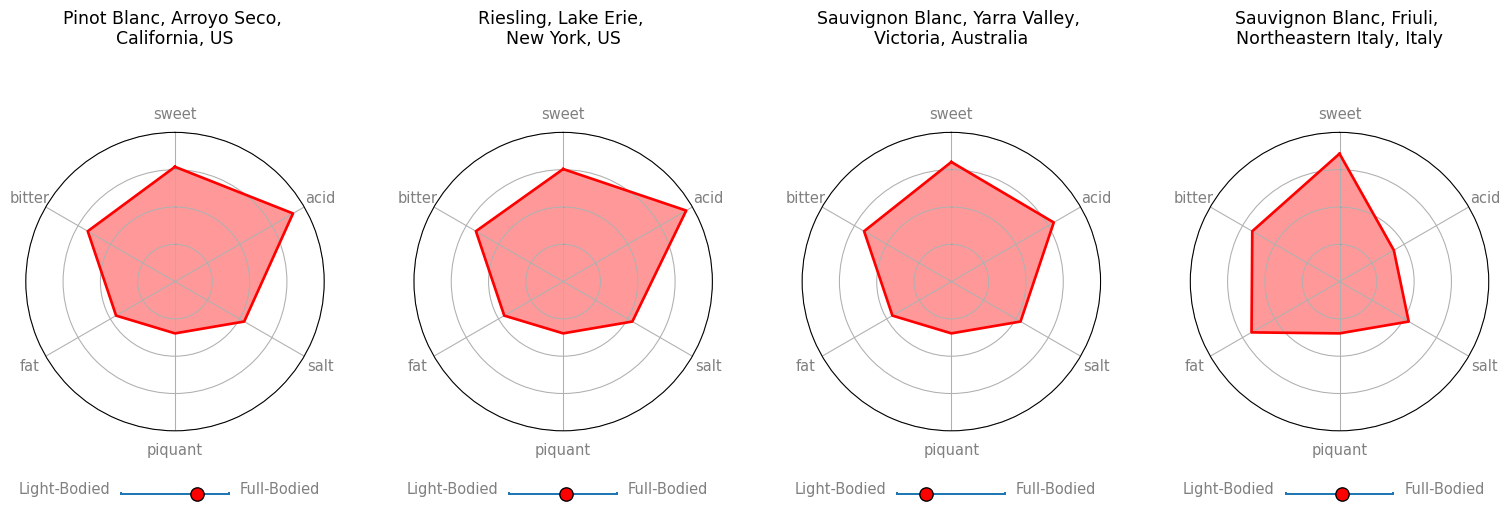

In [83]:
plot_wine_recommendations(wine_names, wine_nonaromas, wine_body) #impactful_descriptors, pairing_types